In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.stats import gamma, halfnorm
from tqdm import tqdm
import corner
import emcee

In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

,x,y,z,w,data,error
0,0.1,-1.439897,0.0,0.25,-2.831628,0.561478
1,0.1,-1.308997,0.5,0.25,-3.006489,0.485720
2,0.1,-1.178097,1.0,0.25,-2.354835,1.270193
3,0.1,-1.047198,1.0,0.25,-2.974002,0.983807
4,0.1,-0.916298,1.0,0.25,-2.401510,1.254378
...,...,...,...,...,...,...
995,0.7,1.570796,-1.0,1.00,-2.287634,2.337560
996,0.8,1.570796,-1.0,1.00,-2.164392,1.612457
997,0.9,1.570796,-1.0,1.00,-2.152368,1.550488
998,1.0,-1.439897,-1.0,1.00,-2.579505,0.442328


In [3]:
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

In [4]:
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1,ym1, zm1, wm1)) ## removing xm for test purposes
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3,ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4,ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)

In [5]:
X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))
#print(D_test.shape,D_train.shape,X_test.shape,X_train.shape)

In [65]:
X = np.column_stack((y, z, w))
D = data.to_numpy().reshape(-1,1)

bounds_l = ((.08, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  # Fix l1 bounds
guess_l = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

kernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
         RBF(length_scale=guess_l, length_scale_bounds=bounds_l)

gpr = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2,normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Fitted Kernel: 0.776**2 * RBF(length_scale=[0.13, 0.706, 0.804, 2.08])


In [18]:
print("gpr.kernel:", gpr.kernel_)

gpr.kernel: 0.775**2 * RBF(length_scale=[0.208, 0.763, 0.698, 2.01])


In [29]:
Dfit1, Dstd1 = gpr.predict(X1, return_std=True)
Dfit2, Dstd2 = gpr.predict(X2, return_std=True)
Dfit3, Dstd3 = gpr.predict(X3, return_std=True)
Dfit4, Dstd4 = gpr.predict(X4, return_std=True)

In [43]:
def log_prior(theta):
    sigma, l1, l2, l3, l4 = theta

    logp_sigma = gamma(a=3, scale=1).logpdf(sigma)
    logp_l1 = gamma(a=2, scale=0.5).logpdf(l1)
    logp_l2 = gamma(a=2, scale=1).logpdf(l2)
    logp_l3 = gamma(a=2, scale=1.5).logpdf(l3)
    logp_l4 = gamma(a=2, scale=2).logpdf(l4)

    return logp_sigma + logp_l1 + logp_l2 + logp_l3 + logp_l4

In [45]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = gpr.log_marginal_likelihood(theta)
    return lp + ll

In [47]:
ndim = 5
nwalkers = 100

# Define sampling ranges in LOG-SPACE (these are your actual desired values)
sigma_range = (0.061, 4.477)   # Log-space for sigma
l1_range = (0.006, 0.605)      # Log-space for l1
l2_range = (0.044, 2.191)      # Log-space for l2
l3_range = (0.077, 2.548)      # Log-space for l3
l4_range = (0.158, 4.0)        # Log-space for l4

# Sample **directly** within the correct log-space bounds
initial_pos = np.array([
    np.random.uniform(*sigma_range, nwalkers),  # sigma (log-space)
    np.random.uniform(*l1_range, nwalkers),  # l1 (log-space)
    np.random.uniform(*l2_range, nwalkers),  # l2 (log-space)
    np.random.uniform(*l3_range, nwalkers),  # l3 (log-space)
    np.random.uniform(*l4_range, nwalkers),  # l4 (log-space)
]).T  # Transpose to shape (nwalkers, ndim)

# Set up the emcee sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run the MCMC sampler for nsteps
nsteps = 800
print("Running MCMC...")
sampler.run_mcmc(initial_pos, nsteps, progress=True)

# Discard some burn-in and thin the chain.
burnin = 200
thin = 15
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

print("Shape of the posterior samples:", samples.shape)

Running MCMC...


100%|██████████| 800/800 [27:27<00:00,  2.06s/it]

Shape of the posterior samples: (4000, 5)


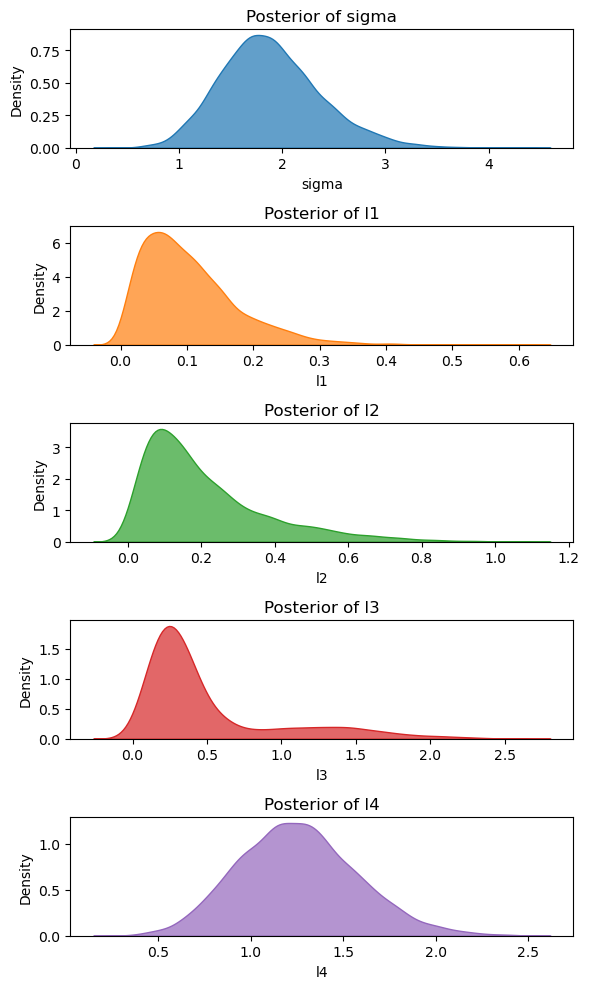

In [85]:
samples = np.array(samples, dtype=np.float64)
samples = samples[~np.isnan(samples).any(axis=1) & ~np.isinf(samples).any(axis=1)]

# Create subplots for smooth density plots
fig, axes = plt.subplots(ndim, 1, figsize=(6, 2 * ndim))

for i in range(ndim):
    sns.kdeplot(samples[:, i], ax=axes[i], fill=True, color=f'C{i}', alpha=0.7)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Density")
    axes[i].set_title(f"Posterior of {labels[i]}")

plt.tight_layout()
plt.show()

In [49]:
# Compute the mean for each hyperparameter (along the sample axis)
mean_values = np.mean(samples, axis=0)
std_values = np.std(samples, axis=0)

# Compute the 2.5th and 97.5th percentiles for a 95% credible interval.
# This returns an array with shape (2, ndim) where the first row is the lower bound and the second is the upper bound.
ci_bounds = np.percentile(samples, [2.5, 97.5], axis=0)

# Print the results for each parameter
labels = ["sigma", "l1","l2", "l3", "l4"]
for i, label in enumerate(labels):
    print(f"{label}: mean = {mean_values[i]:.4f}, std = {std_values[i]:.4f}, 95% CI = [{ci_bounds[0, i]:.4f}, {ci_bounds[1, i]:.4f}]")

sigma: mean = 1.8839, std = 0.4847, 95% CI = [1.0491, 2.9522]
l1: mean = 0.1038, std = 0.0729, 95% CI = [0.0117, 0.2821]
l2: mean = 0.2088, std = 0.1691, 95% CI = [0.0198, 0.6609]
l3: mean = 0.5029, std = 0.4728, 95% CI = [0.0644, 1.7830]
l4: mean = 1.2533, std = 0.3230, 95% CI = [0.6655, 1.9336]


In [71]:
S = len(samples)  # Number of MCMC samples

# Storage for predictions
pred_means = np.zeros((S, len(X1)))
pred_vars = np.zeros((S, len(X1)))
pred_testmeans = np.zeros((S, len(X1_test)))

# Iterate over posterior samples of hyperparameters with a progress bar
for s in tqdm(range(S), desc="Running GP Predictions", unit="sample"):
    theta_s = samples[s]  # Get one sample from posterior
    kernel = gpr.kernel_.clone_with_theta(theta_s)  # Set kernel with sampled hyperparameters
    gp = GaussianProcessRegressor(kernel=kernel,alpha = E_train**2, optimizer= None)  
    gp.fit(X_train, D_train)  # Fit GP with the sampled hyperparameters
    # Predictive mean and variance for X1
    pred_means[s, :], pred_stds = gp.predict(X1, return_std=True)
    pred_vars[s, :] = pred_stds**2  # Convert std deviation to variance

Running GP Predictions: 100%|██████████| 4000/4000 [03:42<00:00, 17.97sample/s]


In [72]:
final_mean = np.mean(pred_means, axis=0)
final_variance = np.mean(pred_vars + pred_means**2, axis=0) - final_mean**2
final_std = np.sqrt(final_variance)
Dfit1 = final_mean
Dstd1 = final_std

In [73]:
x_coords1 = X1_test[:,0]
y_coords1 = X1_test[:,1]

test_indices = np.array([np.where((X1 == test_point).all(axis=1))[0][0] for test_point in X1_test])

Dtrue1 = dm1[test_indices]
Dpred1 = final_mean[test_indices]

rel_diff1 = np.abs(Dtrue1 - Dpred1) / np.abs(Dtrue1)
print(rel_diff1.shape)

(50,)


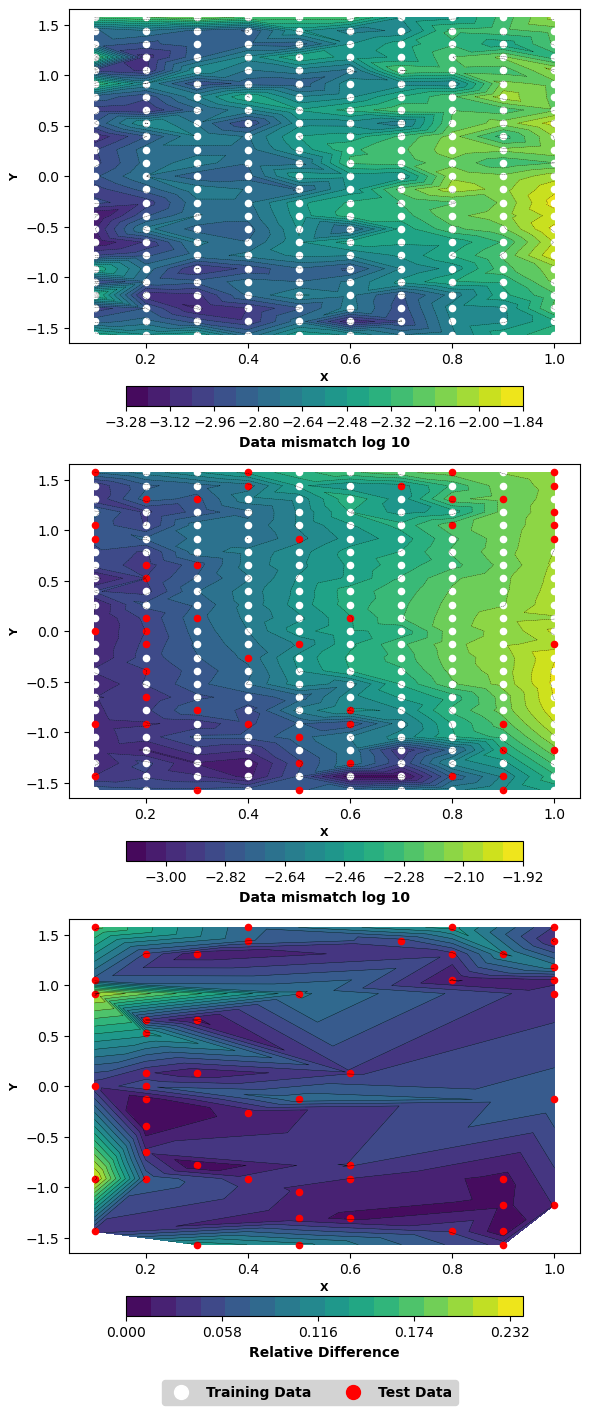

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(6, 15))

# Define custom colormap
viridis_highcontrast = LinearSegmentedColormap.from_list("viridis_highcontrast", plt.cm.viridis(np.linspace(0, 1, 100)))

# Plot True Data
contour1 = axes[0].tricontourf(xm1, ym1, dm1, levels=20, cmap=viridis_highcontrast)
axes[0].tricontour(xm1, ym1, dm1, levels=20, colors='black', linewidths=0.25)
axes[0].scatter(xm1, ym1, s=20, c='white')
axes[0].set_xlim((0.05, 1.05))
axes[0].set_ylim((-1.65, 1.65))
#axes[0].set_title(f'True Data, {title}', size=16, weight='bold')
axes[0].set_xlabel('X', size=8, weight='bold')
axes[0].set_ylabel('Y', size=8, weight='bold')
cbar1 = fig.colorbar(contour1, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.11)
cbar1.set_label("Data mismatch log 10", size=10, weight='bold')

# Plot GPR Model
contour2 = axes[1].tricontourf(xm1, ym1, final_mean, levels=20, cmap=viridis_highcontrast)
axes[1].tricontour(xm1, ym1, final_mean, levels=20, colors='black', linewidths=0.25)
axes[1].scatter(X1_train[:, 0], X1_train[:, 1], s=20, c='white', label='Train')
axes[1].scatter(X1_test[:, 0], X1_test[:, 1], s=20, c='red', label='Test')
axes[1].set_xlim((0.05, 1.05))
axes[1].set_ylim((-1.65, 1.65))
#axes[1].set_title(f'GPR Model, {title}', size=16, weight='bold')
axes[1].set_xlabel('X', size=8, weight='bold')
axes[1].set_ylabel('Y', size=8, weight='bold')
cbar2 = fig.colorbar(contour2, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.11)
cbar2.set_label("Data mismatch log 10", size=10, weight='bold')

# Plot Relative Differences
contour3 = axes[2].tricontourf(x_coords1, y_coords1, rel_diff1, levels=20, cmap=viridis_highcontrast)
axes[2].tricontour(x_coords1, y_coords1, rel_diff1, levels=20, colors='black', linewidths=0.25)
axes[2].scatter(x_coords1, y_coords1, s=20, c='red')
axes[2].set_xlim((0.05, 1.05))
axes[2].set_ylim((-1.65, 1.65))
#axes[2].set_title(f'Relative Differences, {title}', size=16, weight='bold')
axes[2].set_xlabel('X', size=8, weight='bold')
axes[2].set_ylabel('Y', size=8, weight='bold')
cbar3 = fig.colorbar(contour3, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.11)
cbar3.set_label("Relative Difference", size=10, weight='bold')
cbar3.set_ticks(np.around(np.linspace(rel_diff1.min(), rel_diff1.max(), 5), 3))

# Add Legend for Train/Test Data
train_marker = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=10, label='Training Data')
test_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Test Data')

fig.legend(
    handles=[train_marker, test_marker],
    loc='lower center',
    bbox_to_anchor=(0.525, -0.025),
    ncol=2,
    markerscale=1,
    fontsize=14,
    frameon=True,  
    prop={'weight': 'bold'}
)

# Customize the legend background color
legend = fig.legends[0]
legend.get_frame().set_facecolor('lightgrey')  
legend.get_frame().set_edgecolor('lightgrey')  
legend.get_frame().set_alpha(1)

plt.tight_layout(rect=[0, 0, 1, 0.92]) 
plt.show()


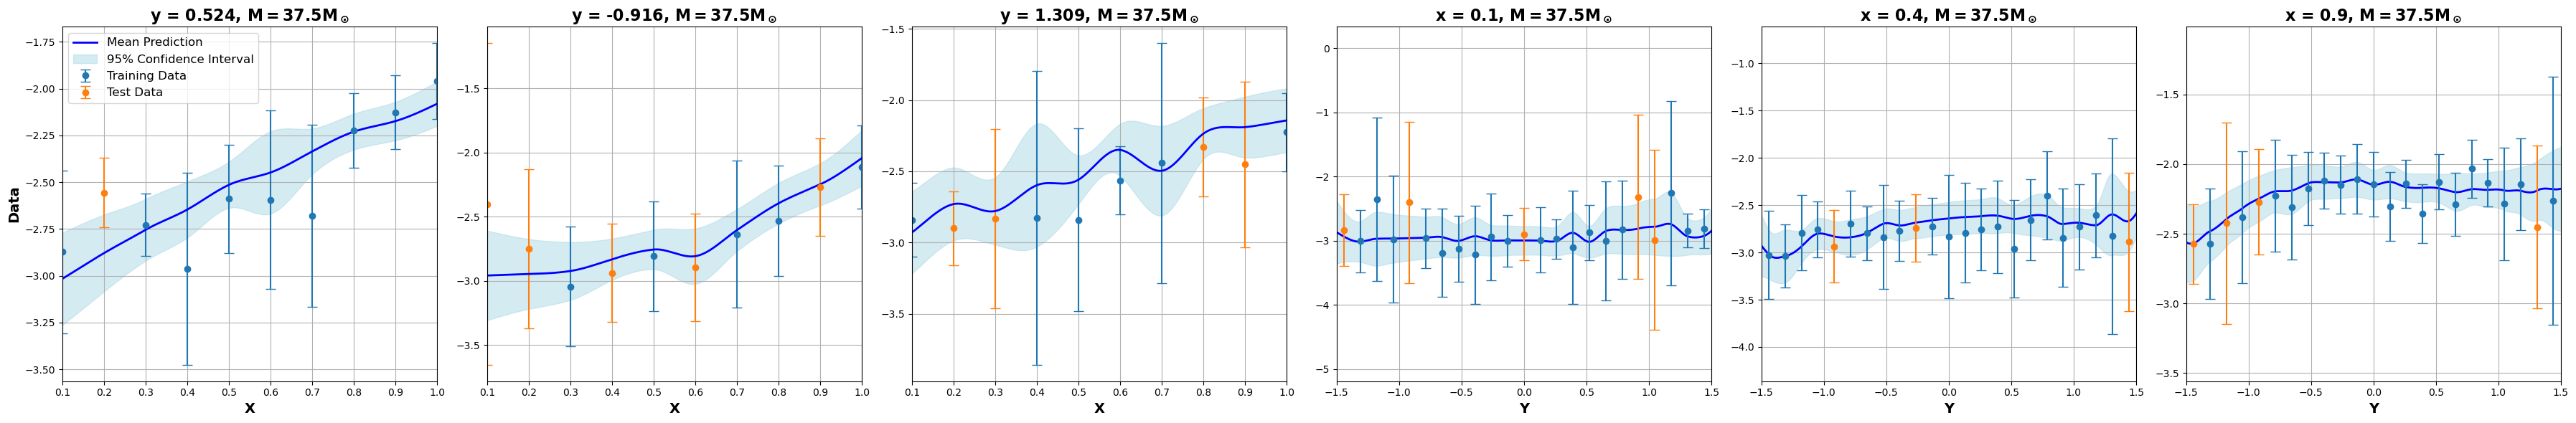

In [75]:
includeerror = 1
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
j = 0

for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoints, ypoint), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoints, ypoint), method="cubic")
        indices1 = np.isclose(y1train,ypoints[i])
        indices2 = np.isclose(y1test,ypoints[i])
        
        if includeerror ==1 :
            ax.errorbar(x1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(), fmt='o', capsize=5,label = 'Training Data')
            ax.errorbar(x1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        else:
            ax.scatter(x1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
            ax.scatter(x1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')
        ax.plot(xpoints, zgridlinear_mean,label='Mean Prediction', color='blue', linewidth=2)
        ax.fill_between(
            xpoints,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoint, ypoints2), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoint, ypoints2), method="cubic")

        indices1 = np.isclose(x1train,xpoint)
        indices2 = np.isclose(x1test,xpoint)
        ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=2)
        if includeerror == 1:
            ax.errorbar(y1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(),fmt='o', capsize=5,label = 'Training Data')
            ax.errorbar(y1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        else:
            ax.scatter(y1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
            ax.scatter(y1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')    
        ax.fill_between(
            ypoints2,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1
        
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

axes[0].legend(fontsize=12,loc='upper left',frameon=True)
legend.get_frame().set_facecolor('white')  # Set the background color to grey
legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)

#plt.savefig("", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()